In [8]:
import scipy
import pylab
import numpy as np
import matplotlib
from matplotlib import colors
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from reproject import reproject_interp
from astropy.convolution import convolve,Gaussian2DKernel
from astropy.table import Table
#Embed plots in Jupyter window
%matplotlib inline

#Set plot fonts
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='sans-serif')


In [2]:
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

### Define physical property functions

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def column_density(Wave, Temp, Kappa, Flux, mu):

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    N = Flux / (mu * (mh*1.e3) * Kappa * B)

    return N

In [3]:
### open files
path = '/Users/hph/cmzoom_catalog/catalog_sept_24/dense_gas_frac/'
hdu1 = fits.open(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')[0]
#hdu2 = fits.open(path+'bolocam_1mm_GC.fits')[0]
hdu3 = fits.open(path+'column_properunits_conv36_source_only.fits')[0]


In [ ]:
###Do reprojections (only if you need to, takes 60s> time >30s)

#array, footprint = reproject_interp(hdu2, hdu1.header)
#fits.writeto(path+'Bolocam_reproject.fits', array,hdu1.header,overwrite=True)

array2, footprint2 = reproject_interp(hdu3, hdu1.header)
fits.writeto(path+'Herschel_reproject.fits', array2,hdu1.header,overwrite=True)

(2800, 19000)


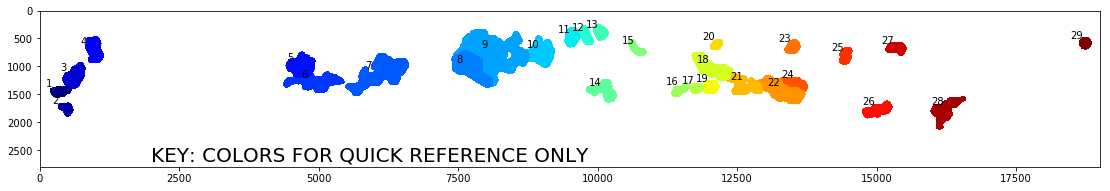

In [4]:
#Examine mask and make a figure to serve as a key
#
# ***Current issues***
#    1- Need to plot in WCS coordinates 
#    2- Source 29 may still need to be excluded (foreground?)

mask = fits.getdata(path+'CMZoom_Mask.fits')


#Label the mask regions
names = pylab.array(['G1.683-0.089','G1.670-0.130','G1.651-0.050','G1.602+0.018',
                    'G1.085-0.027','G1.038-0.074','G0.891-0.048',
                    'G0.699-0.028','G0.619+0.012','G0.489+0.010','G0.412+0.052',
                    'G0.380+0.050','G0.340+0.055','G0.326-0.085',
                    'G0.253+0.016','G0.145-0.086',
                    'G0.106-0.082','G0.070-0.035','G0.068-0.075','G0.054+0.027',
                    'G0.001-0.058','G359.889-0.093','G359.865+0.022',
                    'G359.863-0.069','G359.734+0.002','G359.648-0.133',
                    'G359.611+0.018','G359.484-0.132','G359.137+0.031'])                      

AKAs = pylab.array(['G1.6-a','G1.6-b','G1.6-c','G1.6-d','','','','Sgr B2',
                    'B2-West','e/f','d','c','b','Far-side 1','Brick','Straw',
                    'Sticks','H2CO','Stone','Far-side 2','50 km/s','20 km/s-a',
                    'Far-side 3','20 km/s-b','Far-side 4','','Far-side 5',
                    'Sgr C',''])

Xs = pylab.zeros(29) #Arrays for mean pixel coordinates for each mask
Ys = pylab.zeros(29)

for i in np.arange(0,29):
    where = np.where(mask==i+1)
    Ys[i] = np.mean(where[0]) #save mean pixel coordinates
    Xs[i] = np.mean(where[1])

plot_mask = np.copy(mask) #Make a copy of the mask to mass with for plotting
plot_mask[plot_mask==1000]=np.nan #Set background to nan

print(np.shape(plot_mask))
pylab.figure(1)
fig,ax =  pylab.subplots(figsize=(19,4))
im = ax.imshow(np.flipud(plot_mask),cmap='jet')
for i in np.arange(0,29):
    pylab.text(Xs[i]-250,2700-Ys[i],str(i+1),fontsize=10,color='black')
    
    
pylab.text(2000.,2700.,'KEY: COLORS FOR QUICK REFERENCE ONLY',fontsize=20,color='black')

#pylab.colorbar()
#cbar_ax = fig.add_axes([0.125, 0.06, 0.775, 0.04])
#fig.colorbar(im, orientation="horizontal",cax=cbar_ax)

pylab.savefig(path+'fig_RegionMap.pdf')

/Users/hph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in less
/Users/hph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in less


The SMA column density averages are:
[2.84416319e+22 3.08773842e+22 4.54183000e+22 4.60591407e+22
 8.35143860e+22 1.78839970e+22 2.42681934e+20 1.23355883e+24
 3.09942714e+22 4.66303704e+22 4.14742894e+22 1.61935123e+23
 5.33784025e+22 3.59307441e+22 3.78961110e+22 3.58659394e+22
 5.45893654e+22 3.17641642e+22 3.86360453e+22 5.64725866e+22
 6.15526287e+22 8.42738984e+22 2.50995031e+22 6.16632359e+22
 2.71469028e+22 3.75737572e+22 2.41281698e+22 1.98553745e+22]
The Herschel column density averages are:
[7.05987909e+22 7.67028996e+22 1.02195620e+23 9.98950509e+22
 1.03303913e+23 8.78466428e+22 8.70791313e+22 4.58243998e+23
 1.16150308e+23 1.39436916e+23 9.70747836e+22 6.25317744e+22
 4.86671759e+22 4.19908084e+22 1.72325844e+23 7.85069147e+22
 9.17224155e+22 4.67911341e+22 8.55654150e+22 3.74767574e+22
 8.74596418e+22 1.41623761e+23 3.07408341e+22 1.24537629e+23
 2.25410804e+22 4.38124000e+22 3.55051051e+22 8.06660632e+22]


/Users/hph/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


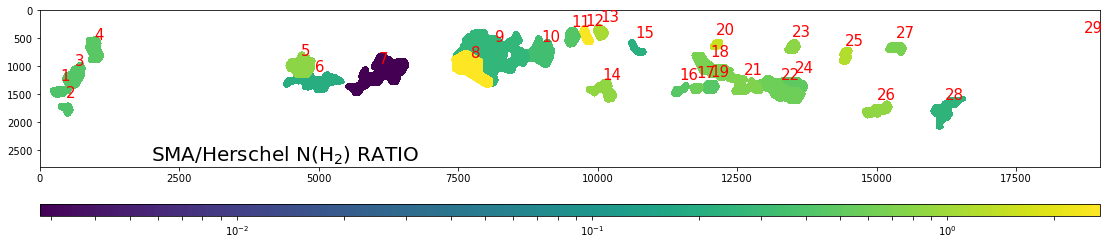

In [6]:
#Sum up signal in SMA map above a certain threshold; take ratio with Bolocam data
#Save mean ratio in each mask, and plot
#
# ***Current issues***
#    1- Bolocam map being used does not cover all of 1.6 cloud 
#    2- Still need to apply factor for the frequency difference between SMA/Bolocam
#    3- bolocam not currently included (should be easy to reintroduce though, I didn't have the FITS file on hand)


SMA = fits.getdata(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')
SMAhead = fits.getheader(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')

Herschel = fits.getdata(path+'Herschel_reproject.fits')
#^herschel column density regridded to match SMA map size, pixelization
Herschelhead = fits.getheader(path+'Herschel_reproject.fits')

Noise = fits.getdata(path+'mosaic_residuals_noisemap_JySr_k20.fits')
Noisehead = fits.getheader(path+'mosaic_residuals_noisemap_JySr_k20.fits')

#Convert SMA mosaic and Noise mosaic from Jy/Sr to Jy/pixel
pix_Sr = 4.25e10 / ((0.5) ** 2  )
New_SMA = SMA / pix_Sr
New_Noise = Noise / pix_Sr

#Convert Bolocam from mJy/beam to Jy/pixel
beam_pix = (2 * np.pi * (33/ 2.35) ** 2  ) / ((0.5) ** 2  )

#we don't actually need most of this, I was just troubleshooting
PixelAreaArcsec = 3600. * abs(SMAhead['CDELT1']) * 3600. * abs(SMAhead['CDELT2'])
PixelSideArcSec = 3600. * abs(SMAhead['CDELT1'])
PixelSidePc = arcsec2pc*PixelSideArcSec
PixelSideCm = PixelSidePc*pc2cm
PixelAreaCm2 = PixelSideCm**2


#Set a noise threshold
New_SMA[New_SMA < New_Noise * 3.0] = np.nan
SMA[SMA < Noise * 3.0] = np.nan


plot_ratio = np.copy(mask) #Make a copy of the mask array to drop values of the SMA/Bolocam ratio into
plot_ratio = 0.0*plot_ratio #Initialize it

SMA_flux=pylab.zeros(28) #Initialize other variables
SMA_flux_mean=pylab.zeros(28)
SMA_flux_mean_pcm2=pylab.zeros(28)
SMA_NH2 = pylab.zeros(28)
B_flux=pylab.zeros(28)
Mass=pylab.zeros(28)
Area=pylab.zeros(28)
Column=pylab.zeros(28)

for i in np.arange(0,28): #loop through each mask
    SMA_flux[i] = np.nansum(New_SMA[(mask>i)*(mask<=i+1)])
    SMA_flux_mean[i] = np.nanmean(SMA[(mask>i)*(mask<=i+1)])
    SMA_NH2[i] = column_density(Wave, dustTemp, Kappa, SMA_flux_mean[i], mu)
    Mass[i] = np.nansum(Herschel[(mask>i)*(mask<=i+1)]) # Sum the Herschel column
    Area[i] = np.nansum(mask[(mask>i)*(mask<=i+1)])/(i+1) #Record mask areas, just in case
    Column[i] = np.nanmean(Herschel[(mask>i)*(mask<=i+1)]) #Grab the average column density
    plot_ratio[(mask>i)*(mask<=i+1)] = (SMA_NH2[i]/Column[i]) #Fill each mask with the ratio of SMA to N_Herschel
print("The SMA column density averages are:")
print(SMA_NH2)
print("The Herschel column density averages are:")
print(Column)
plot_ratio[plot_ratio==0] = np.nan #Set regions outside of the mask to NAN

ratio_list = SMA_NH2/Column

fig,ax = pylab.subplots(figsize=(19,4)) #Define a figure
lognorm = colors.LogNorm(vmin=ratio_list.min(), vmax=ratio_list.max())
im = ax.imshow(np.flipud(plot_ratio),norm=lognorm)
pylab.text(2000,2700,'SMA/Herschel N(H$_2$) RATIO',fontsize=20,color='black')

for i in np.arange(0,29):
    pylab.text(Xs[i],2600-Ys[i],str(i+1),fontsize=15,color='red')

cbar_ax = fig.add_axes([0.125, 0.06, 0.775, 0.04]) #Drop a nice horizontal color bar in
fig.colorbar(im,orientation="horizontal",cax=cbar_ax)

pylab.savefig('fig_RatioMap_smaNH2_by_Herschel.pdf')

In [33]:
## Quick visualization of what the current noise threshold looks like
#
# ***Current issues***
#    1- No noise estimate for tip of Sgr C? Fixed in new residuals I think (hph)
#    2- Inclusion of source 29 which is not in noise map
#    3- doesn't plot (I broke it somehow, will debug soon) (hph)

# masknan = np.isnan(plot_mask)
# all_mask = plot_mask.copy()
# all_mask[masknan==0] = 1

# fig,ax = pylab.subplots(figsize=(19,4)) #Define a figure
# im = ax.imshow(np.flipud(New_SMA*all_mask))
# #pylab.text(2000,2700,'SMA/BOLOCAM FLUX RATIO',fontsize=20,color='black')

# cbar_ax = fig.add_axes([0.125, 0.06, 0.775, 0.04]) #Drop a nice horizontal color bar in
# fig.colorbar(im, orientation="horizontal",cax=cbar_ax)

# pylab.text(2000,2700,'SMA FLUX ABOVE NOISE THRESHOLD',fontsize=20,color='black')

In [37]:
# Make a plot of the flux recovery ratio as a function of mean column density
#
# ***Current issues***
#    1- Bolocam map being used does not cover all of 1.6 cloud 
#    2- Still need to apply factor for the frequency difference between SMA/Bolocam

mymap = pylab.get_cmap("jet") #Define colors that map to the original numbered masks, for fun
colors = np.r_[np.arange(1,29)]
my_colors = mymap(colors)

pylab.figure(1,figsize=(19,5))

pylab.scatter(Column,SMA_NH2,s=70,c=colors,edgecolors='None',cmap=mymap)
#pylab.ylim(0,0.2)

for i in np.arange(3,28):
    pylab.text(Column[i]+0.35,SMA_NH2,str(i+1)) #Throw on some source labels for helpfulness
    
pylab.xlabel('Mean Herschel Column Density (x 10$^{22}$)',fontsize=20)    
pylab.ylabel('Mean SMA Column Density (x 10$^{22}$)',fontsize=20)

pylab.savefig('fig_scatter_N.pdf')

TypeError: only size-1 arrays can be converted to Python scalars

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1143cd730> (for post_execute):


TypeError: only size-1 arrays can be converted to Python scalars

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1368x360 with 1 Axes>

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


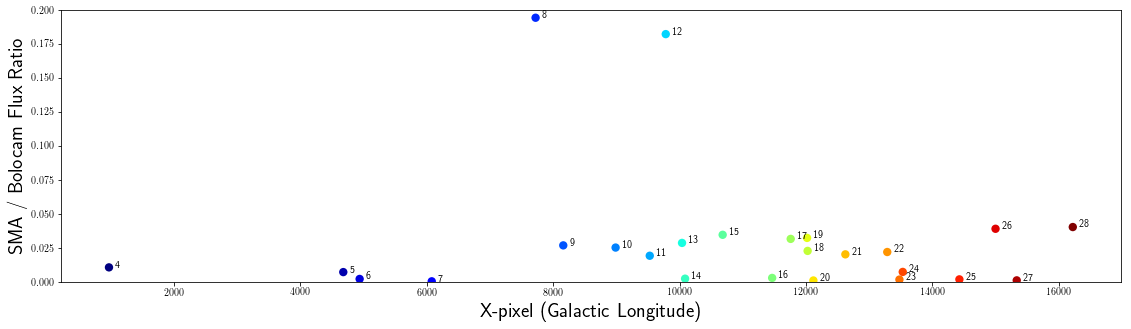

In [12]:
# Make a LaTeX table of this quantity along with other source/mask properties

w = WCS('CMZoom_Mask.fits')

ls = pylab.zeros(29) #Arrays for mean Galactic coordinates for each mask
bs = pylab.zeros(29)

for i in np.arange(0,28):
    ls[i], bs[i] = w.all_pix2world(Xs[i],Ys[i],0)

print('\\begin{table*}[t]')
print('\caption{Source Parameters}')
print('\centering')
print('\\begin{tabular}{lllllll}')
print('\hline\hline')
print(' Identifier  & Name &  Mean $l$ & Mean $b$  & Mask size       & Mean Herschel Column               & SMA to Herschel Ratio \\\\')
print('             &      & ($\degr$) & ($\degr$) & ($\Box\\arcmin$) & $\\times10^{22}$cm$^{-2}$  & \\\\')
print('             &      &           &           &                 &                           & \\\\')                
print('\hline')

for i in np.arange(0,28):
    print('%i & %s & %1.2f & %1.2f & %2.1f & %1.3e & %1.2f  \\\\' %\
                    (i+1,AKAs[i], ls[i],bs[i],Area[i]/ pix_Sr * (180.0/np.pi)**2 * 3600.0,Column[i],SMA_NH2[i]/Column[i]))
        
print('\hline\hline')
print('\end{tabular}')
print('\label{Table}')
print('\\end{table*}')
print(' ')
print(' ')  

\begin{table*}[t]
\caption{Source Parameters}
\centering
\begin{tabular}{lllllll}
\hline\hline
 Identifier  & Name &  Mean $l$ & Mean $b$  & Mask size       & Mean Herschel Column               & SMA to Herschel Ratio \\
             &      & ($\degr$) & ($\degr$) & ($\Box\arcmin$) & $\times10^{22}$cm$^{-2}$  & \\
             &      &           &           &                 &                           & \\
\hline
1 & G1.6-a & 366.69 & 1348.43 & 4.4 & 7.060e+22 & 0.40  \\
2 & G1.6-b & 469.42 & 1041.67 & 3.6 & 7.670e+22 & 0.40  \\
3 & G1.6-c & 624.09 & 1624.59 & 9.3 & 1.022e+23 & 0.44  \\
4 & G1.6-d & 974.25 & 2090.41 & 8.8 & 9.990e+22 & 0.46  \\
5 &  & 4681.27 & 1804.64 & 12.7 & 1.033e+23 & 0.81  \\
6 &  & 4939.91 & 1512.57 & 16.3 & 8.785e+22 & 0.20  \\
7 &  & 6080.80 & 1663.45 & 30.0 & 8.708e+22 & 0.00  \\
8 & Sgr B2 & 7723.55 & 1764.85 & 19.7 & 4.582e+23 & 2.69  \\
9 & B2-West & 8161.49 & 2049.77 & 47.2 & 1.162e+23 & 0.27  \\
10 & e/f & 8989.57 & 2049.88 & 13.7 & 1.394e+23 & 0.33  \\

CMZoom_Mask.fits                                                                 [astropy.io.fits.card]


In [34]:
### build astropy table for cara
tabledata = [np.linspace(1,28,28), AKAs, ls, bs, Area/ pix_Sr * (180.0/np.pi)**2 * 3600.0,Column,SMA_NH2,SMA_NH2/Column]
### get rid of last index for now
for i in range(len(tabledata)):
    if len(tabledata[i])==29:
        tabledata[i] = tabledata[i][0:28]
###load data into table
dtable = Table(tabledata, 
               names=('Identifier', 'Name', 'Mean $l$', 'Mean $b$','Mask size','Mean Herschel Column','Mean SMA Column','SMA to Herschel Ratio'), 
               meta={'name': 'first table'})

In [32]:
dtable

Identifier,Name,Mean $l$,Mean $b$,Mask size,Mean Herschel Column,Mean SMA Column,SMA to Herschel Ratio
float64,str10,float64,float64,float64,float64,float64,float64
1.0,G1.6-a,366.6853017921595,1348.4342744644614,4.4492376537974465,7.059879093499454e+22,2.844163190876994e+22,0.4028628752999216
2.0,G1.6-b,469.42279390236763,1041.6735307321453,3.5616286107561534,7.670289955757383e+22,3.087738417316792e+22,0.40255823901404275
3.0,G1.6-c,624.0916061189735,1624.5871849598786,9.34791080753709,1.0219562014568518e+23,4.5418300045784955e+22,0.4444251131412364
4.0,G1.6-d,974.2493455857499,2090.405949077531,8.843625406673873,9.98950509032166e+22,4.605914065774561e+22,0.46107530094128535
5.0,,4681.266343560166,1804.638665321608,12.679851113295715,1.0330391254630484e+23,8.351438599188038e+22,0.808433910520533
6.0,,4939.911414107728,1512.5686958603765,16.25934591484617,8.78466427681231e+22,1.7883997018914806e+22,0.20358202038660458
7.0,,6080.804622441941,1663.4457119977042,30.03647311957075,8.70791313060578e+22,2.4268193444768118e+20,0.0027869126713577887
8.0,Sgr B2,7723.549587039839,1764.8521793548205,19.662264356017165,4.58243997966515e+23,1.2335588317228728e+24,2.691925780145214
9.0,B2-West,8161.489722101638,2049.77384503322,47.242171000497834,1.1615030789409042e+23,3.0994271433749177e+22,0.26684622706304617


In [35]:
### save table
dtable.write(path+'DenseGasFrac_table.fits')